# EQS GB Cross-Validation for Simple sources

Using cross-validation to determine the best damping and depth for the model.

In [1]:
import warnings
import itertools
import numpy as np
import verde as vd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import eqs_magnetics as eqs

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)

Set the data coordinates and field direction.

N data: 92046


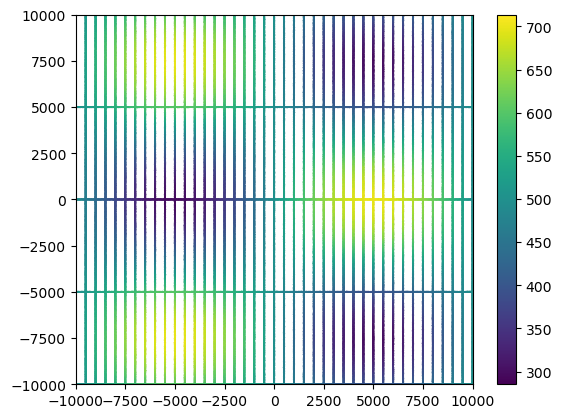

In [3]:
region = [-10e3, 10e3, -10e3, 10e3]
# Inc and dec from the IGRF around Antarctica
field_direction = eqs.angles_to_vector(inclination=84, declination=120, amplitude=1)
#field_direction = eqs.angles_to_vector(inclination=14, declination=122, amplitude=1)

# Generate fake flight lines
easting, northing = [c.ravel() for c in vd.grid_coordinates(region, spacing=(10, 500))]
easting_tie, northing_tie = [c.ravel() for c in vd.grid_coordinates(region, spacing=(5000, 10))]
easting = np.concatenate([easting, easting_tie])
northing = np.concatenate([northing, northing_tie])
upward = vd.synthetic.CheckerBoard(region=region, amplitude=200, w_east=20000, w_north=15000).predict((easting, northing)) + 500
coordinates = (easting, northing, upward)
for i, c in enumerate(coordinates):
    eqs.contaminate(c, standard_deviation=5, random_state=i)

print("N data:", coordinates[0].size)

plt.scatter(*coordinates[:2], c=coordinates[2], s=0.1)
plt.xlim(*region[:2])
plt.ylim(*region[2:])
plt.colorbar()
plt.show()

Create the dipole source model.

In [4]:
source_inc, source_dec = 70, 90
#source_inc, source_dec = 15, 45
dipole_moments = []
source_coordinates = []

# Dike NE-SW
dike_moment_magnitude = 10e7
source_coordinates.append(vd.profile_coordinates((-20e3, -5e3), (20e3, 12e3), size=1000, extra_coords=0)[0])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(1000, dike_moment_magnitude)))

# Dike NW-SE
source_coordinates.append(vd.profile_coordinates((20e3, -10e3), (-20e3, 25e3), size=1000, extra_coords=0)[0])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(1000, dike_moment_magnitude)))

# Dike small
source_coordinates.append(vd.profile_coordinates((20e3, -4e3), (4e3, 3e3), size=1000, extra_coords=0)[0])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(1000, dike_moment_magnitude)))

# # Dike very small
source_coordinates.append(vd.profile_coordinates((3e3, 3.5e3), (-0.5e3, 5.5e3), size=100, extra_coords=0)[0])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(100, dike_moment_magnitude)))

# point source top left
source_coordinates.append([[-7500], [7000], [-350]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, 1e10))

# point source centre
source_coordinates.append([[0], [-100], [-1e3]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, 5e10))

# point source bottom right
source_coordinates.append([[7500], [-7500], [-500]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, 2e10))

# point source bottom left
source_coordinates.append([[-8000], [-6000], [-800]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, 5e10))

# regional
source_coordinates.append([[2e3, -5e3], [-9e3, 5e3], [-8e3, -8e3]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(2, 1e13)))

source_coordinates = np.concatenate(source_coordinates, axis=1)
dipole_moments = np.concatenate(dipole_moments, axis=1)
dipole_moments.shape, source_coordinates.shape

((3, 3106), (3, 3106))

In [5]:
magnetic_field = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.core.typeinfer.CallConstraint object at 0x7f411abd4eb0>.
[1m[1m[1mmissing a required argument: 'magnetic_moment'[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function magnetic_field at 0x7f4124e321f0>))[0m
[0m[1mDuring: typing of call at /home/jupyter-india/eqs-gb-norm-of-b/code/eqs_magnetics.py (103)
[0m
Enable logging at debug level for details.
[1m
File "eqs_magnetics.py", line 103:[0m
[1mdef _dipole_magnetic_field_fast(
    <source elided>
        for j in range(d_easting.size):
[1m            field = choclo.dipole.magnetic_field(
[0m            [1m^[0m[0m


In [ ]:
total_field_anomaly = eqs.contaminate(
    eqs.total_field_anomaly(magnetic_field, field_direction), standard_deviation=50, random_state=42,
)
bnorm = eqs.magnetic_field_norm(magnetic_field)

In [ ]:
plt.figure(figsize=(15,5))
scale = vd.maxabs(total_field_anomaly)
#scale = 1000
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=total_field_anomaly, cmap="RdBu_r", s=0.5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

scale_bnorm = vd.maxabs(bnorm)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm, cmap="RdBu_r", s=0.5, vmin=-scale_bnorm, vmax=scale_bnorm)
plt.title("Norm of B of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit deep sources

Block reduce the data has several advantages:

1. Less data to fit so much faster.
2. The block median reduces the wavelengths in the data, which captures the regional field and leaves the residuals alone.

In [ ]:
reducer = vd.BlockReduce(reduction=np.median, spacing=2e3, drop_coords=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=total_field_anomaly)

In [ ]:
plt.figure()
plt.scatter(*coords_blocked[:2], c=tfa_blocked, cmap="RdBu_r", s=5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

In [ ]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(damping=1e-5)
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

In [ ]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = total_field_anomaly - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coords_blocked[:2], c=tfa_deep_blocked, cmap="RdBu_r", s=5, vmin=-scale, vmax=scale)
plt.title("TFA prediction (blocked)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="RdBu_r", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the shallow residuals with gradient-boosted sources

In [ ]:
dampings = [1e1]
depths = [700, 900]
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
print("Combinations:", parameter_sets)

In [ ]:
%%time
kfold = vd.BlockKFold(
    spacing=500,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
for parameters in parameter_sets:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=100, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores.append(np.mean(tmp))

In [ ]:
best = np.argmin(scores)
parameter_sets[best]

In [ ]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=100, **parameter_sets[best])
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

In [ ]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="RdBu_r", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals prediction")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, s=1)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict the norm of B

In [ ]:
grid_coordinates = vd.grid_coordinates(region, spacing=100, extra_coords=500)
true_norm_of_b = np.sqrt(sum(c**2 for c in eqs.dipole_magnetic(grid_coordinates, source_coordinates, dipole_moments)))
predicted_norm_of_b = np.sqrt(sum(c**2 for c in eqs_deep.predict(grid_coordinates) + eqs_shallow.predict(grid_coordinates)))
error = true_norm_of_b - predicted_norm_of_b

In [ ]:
scale_b = vd.maxabs(true_norm_of_b)
plt.figure()
plt.pcolormesh(*grid_coordinates[:2], true_norm_of_b, cmap="RdBu_r", vmin=-scale_b, vmax=scale_b)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.figure()
plt.pcolormesh(*grid_coordinates[:2], predicted_norm_of_b, cmap="RdBu_r", vmin=-scale_b, vmax=scale_b)
plt.title("Predicted norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.figure()
diff_scale = vd.maxabs(error)
plt.pcolormesh(*grid_coordinates[:2], error, cmap="RdBu_r", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")